# Looking for the inversion in the ERA5 model

*Data is downloaded from the Copernicus site: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels?tab=overview* 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

from metpy.plots import SkewT
from metpy.units import units

In [2]:
date_str = "20240620"

latitude = 43.8
longitude = -66.1
#--- ERA5 data is already downloaded for these coordinates

In [3]:
era5_file = 'model_data/era5_'+date_str+'_00z.nc'
era5_ds = xr.open_dataset(era5_file)

In [4]:
sst_file = "sst_data/sst_"+date_str

sst_ds = xr.open_dataset(sst_file)
sst_ds =  sst_ds.squeeze()

#--- Convert from C to K
sst_ds.sst.values = sst_ds.sst.values+273.15

In [5]:
surface = sst_ds.sel(lat=latitude, lon=longitude+360, method='nearest')

In [6]:
datetime_str = np.datetime_as_string(era5_ds.valid_time.values[0], unit='h')
datetime_str = datetime_str.replace('T', ' ')+"Z"
print(datetime_str)

2004-06-20 00Z


In [7]:
era5_ds

<xarray.Dataset> Size: 240B
Dimensions:         (valid_time: 1, pressure_level: 12, latitude: 1,
                     longitude: 1)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 8B 2004-06-20
  * pressure_level  (pressure_level) float64 96B 1e+03 975.0 ... 750.0 700.0
  * latitude        (latitude) float64 8B 43.7
  * longitude       (longitude) float64 8B -66.2
    expver          <U4 16B ...
Data variables:
    q               (valid_time, pressure_level, latitude, longitude) float32 48B ...
    t               (valid_time, pressure_level, latitude, longitude) float32 48B ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-03T17:16 GRIB to CDM+CF via cfgrib-0.9.1...

In [8]:
pressure = era5_ds.pressure_level.values
surface_temperature = float(surface.sst.values)
temperature = era5_ds.t.squeeze().values

In [9]:
#--- Converting from specific humidity to dewpoint

from metpy.calc import dewpoint

specific_humidity = era5_ds.q.squeeze().values
mixing_ratio = specific_humidity / (1 - specific_humidity)
vapor_pressure = (mixing_ratio * pressure) / (0.622 + mixing_ratio)
dewpoints = dewpoint(vapor_pressure * units("hPa"))

In [10]:
temperature_C = temperature - 273.15

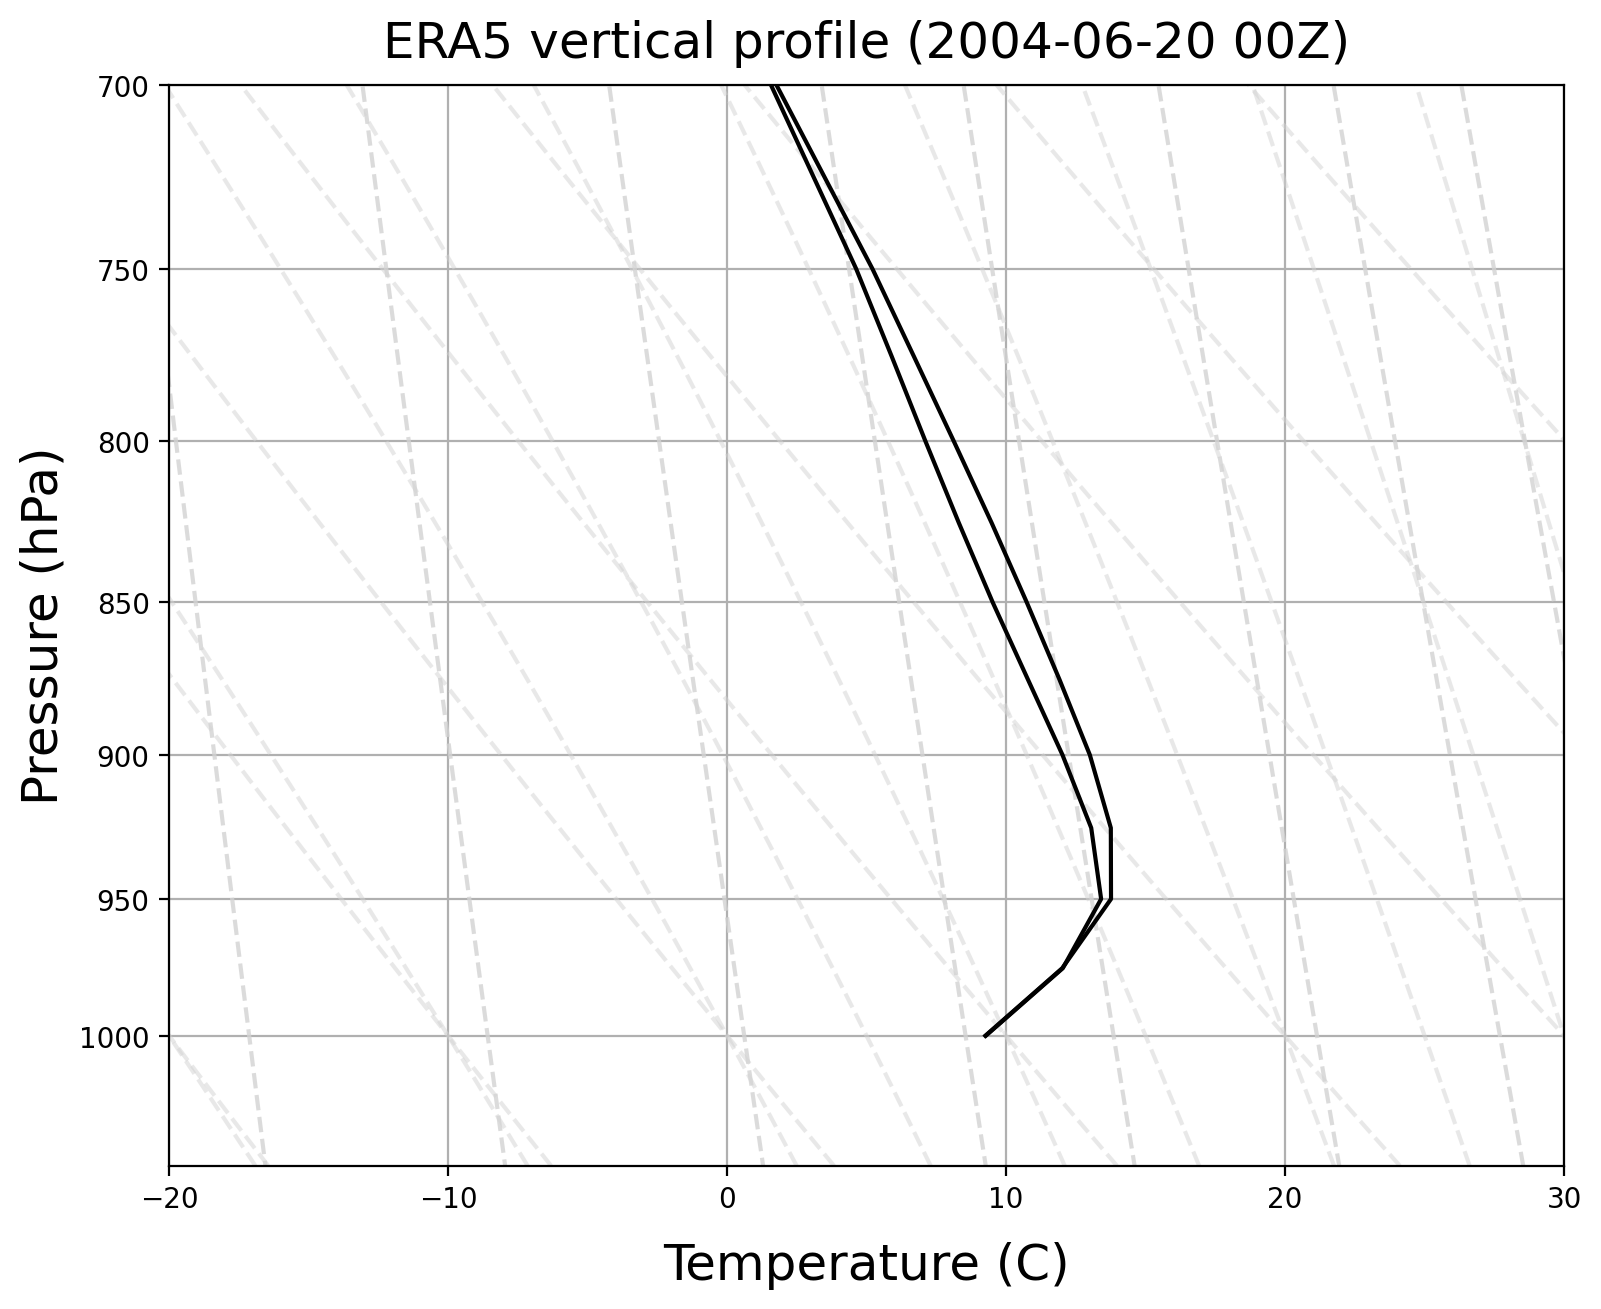

In [11]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, aspect=220, rotation=0)

# Plot the data
skew.plot(pressure, temperature_C, 'k', label='Temperature')
skew.plot(pressure, dewpoints, 'k', label='Dewpoint')

# Add additional lines (like dry adiabats, moist adiabats, and mixing ratio lines)
skew.plot_dry_adiabats(colors='lightgray')
skew.plot_moist_adiabats(colors='lightgray')
skew.plot_mixing_lines(colors='lightgray')

# Set plot limits and labels
skew.ax.set_ylim(1050, 700)
skew.ax.set_yticks(np.arange(1000, 700 - 1, -50))
skew.ax.set_xlim(-20, 30)
skew.ax.set_xlabel('Temperature (C)', size=18, labelpad=10)
skew.ax.set_ylabel('Pressure (hPa)', size=18)

skew.ax.set_title('ERA5 vertical profile ('+ datetime_str+')', size=18, pad=10)
# Show the plot
fig.set_dpi(200)
plt.show()